## 4. Data Modelling

### Import Libraries and Data

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
# Set plot theme 
plt.style.use('Solarize_Light2')

In [3]:
# Import processed data
df_processed = pd.read_csv('../Data/data_processed10.csv', index_col='Unnamed: 0')

In [4]:
# Get column names and check for null values
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27620 entries, 0 to 27619
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_suicidewatch  27620 non-null  bool   
 1   author           27620 non-null  object 
 2   num_comments     27620 non-null  int64  
 3   score            27620 non-null  int64  
 4   upvote_ratio     27620 non-null  float64
 5   link_flair_text  27620 non-null  object 
 6   flair_group      27620 non-null  object 
 7   alltext          27620 non-null  object 
 8   repost           27620 non-null  bool   
 9   dual_user        27620 non-null  bool   
 10  clean_alltext    27620 non-null  object 
 11  word_count       27620 non-null  int64  
dtypes: bool(3), float64(1), int64(3), object(5)
memory usage: 2.2+ MB


### Modelling

We will start with a Logistic regression model, Multinomial Naive Bayes, and then a Random forest model.

Firstly we would use Logistic Regression because it suits data that has lower bias but higher variance compared to Naive Bayes, and based on our understanding of our data, it has high variance given that there is quite a number of overlap between the top-20 words, and the df threshold had to be set high for significant results. Also we observed that there people who post in r/MentalHealth that are having suicidal thoughts.

Next we would use Naive Bayes as a comparison, using the multinomial version because the variable values can be integers of more than 1.

We will use Random Forest last, as Logistic Regression and Mulinomial Naive Bayes makes the assumption that variables are independent, but it is not a requirement for Random Forest, but Random Forest is prone to overfitting and takes longer to run. 

Baseline model: there is a 44% baseline accuracy if all posts were to be assigned to r/SuicideWatch

In [5]:
# Baseline score
df_processed['is_suicidewatch'].value_counts(normalize=True)

False    0.560536
True     0.439464
Name: is_suicidewatch, dtype: float64

#### Set Feature (X) and Target (y) variables

Our features will be the cleaned text from subreddit title and posts, and the target will be `is_suicidewatch`, True = post is from r/SuicideWatch, False = post is from r/MentalHealth.

In [101]:
# Select Features
X = df_processed['clean_alltext']
y = df_processed['is_suicidewatch']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [214]:
# reload custom stopwords used in EDA
custom_stopwords = stopwords.words('english') + ['suicide','mental','health','reddit','subreddit']

#### Logistic Regression

Firstly, we would run models using LogisticRegression, with two different vectorizers,  CountVectorizer and TfidfVectorizer.

In [43]:
# Setup two pipelines for LogisticRegression, first with CountVectorizer and second with TfidfVectorizer
pipe1 = Pipeline([('cvec1', CountVectorizer(stop_words= custom_stopwords)),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer(stop_words= custom_stopwords)),
                  ('logreg2', LogisticRegression())
                 ])

In [44]:
# Set up 
pipe1_params = {'cvec1__max_features': [500, 1000],
                'cvec1__max_df': [0.95, 0.97],
                'cvec1__min_df': [0.05, 0.03],
                'cvec1__ngram_range': [(1,1), (1,2)],
                'logreg1__max_iter': [1000]
               }

pipe2_params = {'tfvec2__max_features': [500, 1000],
                'tfvec2__max_df': [0.95, 0.97],
                'tfvec2__min_df': [0.05, 0.03],
                'tfvec2__ngram_range': [(1,1) , (1,2)],
                'logreg2__max_iter': [1000]
               }

In [45]:
# Creating two separate GridSearchCV objects for:
# CountVectorizer and TfidfVectorizer
gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5, verbose=1, n_jobs=-1)
gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5, verbose=1, n_jobs=-1)

In [46]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.
gs_pipe1.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [47]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [48]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.
gs_pipe1.best_params_

{'cvec1__max_df': 0.95,
 'cvec1__max_features': 500,
 'cvec1__min_df': 0.03,
 'cvec1__ngram_range': (1, 1),
 'logreg1__max_iter': 1000}

In [49]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.
gs_pipe2.best_params_

{'logreg2__max_iter': 1000,
 'tfvec2__max_df': 0.95,
 'tfvec2__max_features': 500,
 'tfvec2__min_df': 0.03,
 'tfvec2__ngram_range': (1, 2)}

In [50]:
# Summary scores of CountVectorizer and LogisticRegression.
print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.786

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.8
Testing corpus accuracy = 0.783


In [51]:
# Summary scores of TfidfVectorizer and LogisticRegression.
print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.792

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.802
Testing corpus accuracy = 0.792


In [79]:
# Creacting a summary dataframe.
summary_df = pd.DataFrame(columns=[
    'transformer_estimator', 
    'best_score', 
    'accuracy', 
    'sensitivity',
    'specificity',
    'best_params', 
])

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


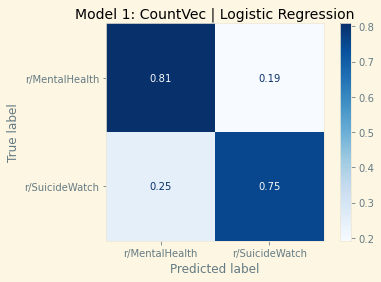

In [81]:
#Generate confusion matrix
y_pred = gs_pipe1.predict(X_test)
confusion_matrix(y_test, # True values.
                 y_pred)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

# Adding the scores into summary_df
summary_df.loc[1] = [
    'CountVec | LogisticRegression',
    round(gs_pipe1.best_score_, 3),
    round(metrics.accuracy_score(y_test, y_pred),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    str(gs_pipe1.best_params_),
]

# Plot Confusion Matrix
plot_confusion_matrix(gs_pipe1, X_test, y_test, cmap='Blues', 
                      display_labels=['r/MentalHealth', 'r/SuicideWatch'],
                      normalize='true');  
plt.title(label="Model 1: CountVec | Logistic Regression", fontsize=14)
plt.grid(False)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


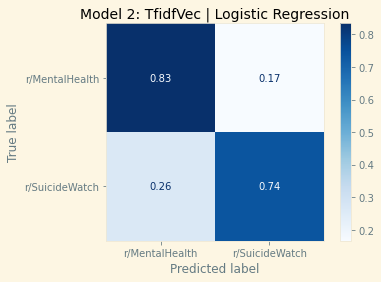

In [82]:
#Generate confusion matrix
y_pred = gs_pipe2.predict(X_test)
confusion_matrix(y_test, # True values.
                 y_pred)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

# Adding the scores into summary_df.
summary_df.loc[2] = [
    'TfidfVec | LogisticRegression',
    round(gs_pipe2.best_score_, 3),
    round(metrics.accuracy_score(y_test, y_pred),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    str(gs_pipe2.best_params_),
]

# Plot Confusion Matrix
plot_confusion_matrix(gs_pipe2, X_test, y_test, cmap='Blues', 
                      display_labels=['r/MentalHealth', 'r/SuicideWatch'],
                      normalize='true');  
plt.title(label="Model 2: TfidfVec | Logistic Regression", fontsize=14)
plt.grid(False)

In [83]:
summary_df

,transformer_estimator,best_score,accuracy,sensitivity,specificity,best_params
1,CountVec | LogisticRegression,0.786,0.783,0.751,0.808,"{'cvec1__max_df': 0.95, 'cvec1__max_features':..."
2,TfidfVec | LogisticRegression,0.792,0.792,0.739,0.834,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': ..."


We find that TfidfVec has better Accuracy and Specificity compared to CountVec. TF-IDF considers the frequency of words relative to the total size of the document, as opposed to CountVec which does a simple count.

#### Model 3: MultinomialNB

Next, we would run a model using MultinomialNB. We would choose TfidfVec as the vectorizer as it was the better performing one in the previous section.

In [12]:
# Set up MultinomialNB and TfidfVectorizer pipeline
pipe3 = Pipeline([
    ('tfvec3', TfidfVectorizer(stop_words= custom_stopwords)),
    ('nb3', MultinomialNB())
])

ERROR! Session/line number was not unique in database. History logging moved to new session 671


In [13]:
# Define parameters
pipe_params3 = {
    'tfvec3__max_features': [300, 500, 700],
    'tfvec3__min_df': [.05, .03],
    'tfvec3__max_df': [.95, .97],
    'tfvec3__ngram_range': [(1,1), (1,2)],
    'nb3__alpha': [0.1, 0.37, 0.5]
}

In [14]:
# Instantiate GridSearchCV.
gs_pipe3 = GridSearchCV(pipe3, 
                  param_grid=pipe_params3,
                  cv=5, 
                   verbose=1,
                   n_jobs=-1
                  )

In [15]:
# Fit GridSearch to training data.
gs_pipe3.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec3',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [17]:
# Best parameters of TfidfVectorizer and MultinomialNB.
print(gs_pipe3.best_params_)

{'nb3__alpha': 0.37, 'tfvec3__max_df': 0.95, 'tfvec3__max_features': 500, 'tfvec3__min_df': 0.03, 'tfvec3__ngram_range': (1, 2)}


In [92]:
# Summary scores of TfidfVectorizer and MultinomialNB.
print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.774

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.779
Testing corpus accuracy = 0.775


In [19]:
gs_pipe3.best_estimator_[0]

TfidfVectorizer(max_df=0.95, max_features=500, min_df=0.03, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [20]:
gs_pipe3.best_estimator_[0].get_feature_names_out()

array(['10', 'able', 'absolutely', 'actually', 'advice', 'afraid', 'age',
       'ago', 'alive', 'almost', 'alone', 'already', 'also', 'always',
       'angry', 'another', 'anxiety', 'anxious', 'anymore', 'anyone',
       'anyone else', 'anything', 'anyway', 'around', 'ask', 'asked',
       'asking', 'away', 'back', 'bad', 'barely', 'basically', 'become',
       'bed', 'believe', 'best', 'better', 'big', 'bit', 'body',
       'boyfriend', 'brain', 'break', 'bring', 'broke', 'brother', 'call',
       'called', 'came', 'cannot', 'cannot even', 'car', 'care', 'change',
       'child', 'close', 'college', 'come', 'comes', 'coming',
       'completely', 'constant', 'constantly', 'control', 'could',
       'couple', 'cry', 'crying', 'currently', 'cut', 'dad', 'day',
       'days', 'dead', 'deal', 'death', 'decided', 'depressed',
       'depression', 'deserve', 'diagnosed', 'die', 'different',
       'disorder', 'done', 'due', 'eat', 'eating', 'either', 'else',
       'emotions', 'end', 'ende

In [21]:
len(gs_pipe3.best_estimator_[1].coef_.tolist()[0])

423

In [23]:
gs_pipe3.best_estimator_[1].coef_
feature_list = []
for x, y in zip(gs_pipe3.best_estimator_[0].get_feature_names_out(), 
                gs_pipe3.best_estimator_[1].coef_.tolist()[0]) :
    feature_list.append([x,y])

#if using logistic regr you can sort this by the coeff to see which one is most impactfulf

In [24]:
feature_df = pd.DataFrame(feature_list, columns=['feature','coef'])

In [25]:
# Top Features by coefficients
feature_df.sort_values('coef', ascending=False).head(10)

,feature,coef
393,want,-4.110029
209,life,-4.362837
49,cannot,-4.417985
210,like,-4.489916
117,feel,-4.528787
198,know,-4.639818
417,would,-4.647249
81,die,-4.725680
18,anymore,-4.749985
149,going,-4.753205


C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


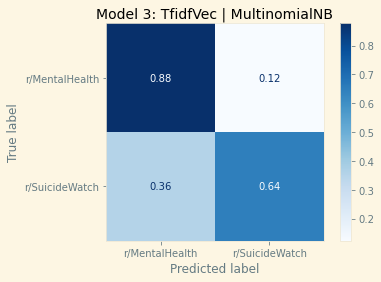

In [84]:
# Generate confusion matrix
y_pred = gs_pipe3.predict(X_test)
confusion_matrix(y_test, # True values.
                 y_pred)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

# Adding the scores into summary_df.
summary_df.loc[3] = [
    'TfidfVec | MultinomialNB',
    round(gs_pipe3.best_score_, 3),
    round(metrics.accuracy_score(y_test, y_pred),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    str(gs_pipe3.best_params_),
]

# Plot Confusion Matrix
plot_confusion_matrix(gs_pipe3, X_test, y_test, cmap='Blues', 
                      display_labels=['r/MentalHealth', 'r/SuicideWatch'],
                      normalize='true');  
plt.title(label="Model 3: TfidfVec | MultinomialNB", fontsize=14)
plt.grid(False)

### RandomForest

We will now do a Random Forest test with features from the dataset and Sentiment and LDA features. We would use the optimal parameters for TfidfVectorizer from model 3.

In [28]:
#Create an instance of `RandomForestClassifier`
pipe4 = Pipeline([('tfvec4', TfidfVectorizer(stop_words= custom_stopwords)),
                  ('rf', RandomForestClassifier())
                 ])

In [57]:
# Define parameters for GridSearchCV 200, 300, 
pipe4_params = {
    'tfvec4__max_df': [0.95], 
    'tfvec4__max_features': [500], 
    'tfvec4__min_df': [0.03], 
    'tfvec4__ngram_range': [(1, 2)],
    'rf__n_estimators': [200, 300, 400],
    'rf__max_features': ['sqrt']
    ,
}

In [58]:
gs_pipe4 = GridSearchCV(pipe4, 
                  param_grid=pipe4_params, 
                  cv=5,
                    verbose=1,
                   n_jobs=-1
                 )
gs_pipe4.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec4',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [89]:
gs_pipe4.best_params_

{'rf__max_features': 'sqrt',
 'rf__n_estimators': 400,
 'tfvec4__max_df': 0.95,
 'tfvec4__max_features': 500,
 'tfvec4__min_df': 0.03,
 'tfvec4__ngram_range': (1, 2)}

In [90]:
# Summary scores of TfidfVectorizer and RandomForest.
print("TfidfVectorizer with RandomForest summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe4.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe4.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe4.score(X_test, y_test), 3)}")

TfidfVectorizer with RandomForest summary of accuracy scores:
GridSearchCV best accuracy = 0.781

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.998
Testing corpus accuracy = 0.776


C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


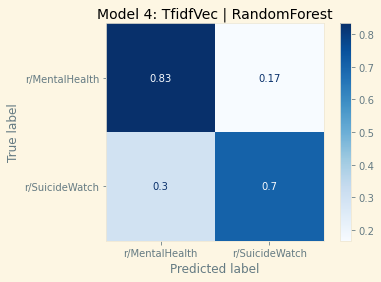

In [85]:
# Generate confusion matrix
y_pred = gs_pipe4.predict(X_test)
confusion_matrix(y_test, # True values.
                 y_pred)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

# Adding the scores into summary_df.
summary_df.loc[4] = [
    'TfidfVec | RandomForest',
    round(gs_pipe4.best_score_, 3),
    round(metrics.accuracy_score(y_test, y_pred),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    str(gs_pipe4.best_params_),
]

# Plot Confusion Matrix
plot_confusion_matrix(gs_pipe4, X_test, y_test, cmap='Blues', 
                      display_labels=['r/MentalHealth', 'r/SuicideWatch'],
                      normalize='true');  
plt.title(label="Model 4: TfidfVec | RandomForest", fontsize=14)
plt.grid(False)

In [86]:
display(summary_df)

,transformer_estimator,best_score,accuracy,sensitivity,specificity,best_params
1,CountVec | LogisticRegression,0.786,0.783,0.751,0.808,"{'cvec1__max_df': 0.95, 'cvec1__max_features':..."
2,TfidfVec | LogisticRegression,0.792,0.792,0.739,0.834,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': ..."
3,TfidfVec | MultinomialNB,0.774,0.775,0.644,0.877,"{'nb3__alpha': 0.37, 'tfvec3__max_df': 0.95, '..."
4,TfidfVec | RandomForest,0.781,0.776,0.704,0.833,"{'rf__max_features': 'sqrt', 'rf__n_estimators..."


Looking at the results, the best score and accuracy are quite similar for all models, but sensitivity and specificity is a lot more varied. 

Hence to answer our research question, we would prioritize specificity, and would choose model 3, TfidfVec with MultinomialNB.

#### Error Analysis and Model Tuning

We would do a False Postive error analysis on the results model 3 by flair category, of particular interest would be the false positive rate of the `Positive` category of flairs which we would expect low false positives as these are expected to be of happier sentiment.

We will look at the posts wrongly classified as r/SuicideWatch in the `Positive` category, and compare the keywords with True Positive in r/SuicideWatch. For the closely overlapping keywords, we will add this to the stopwords list and rerun the classification model.

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


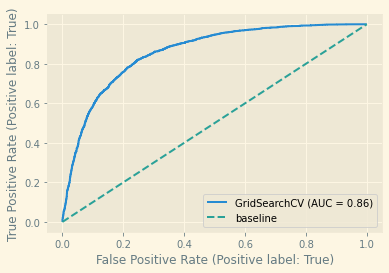

In [196]:
# Plot ROC curve
plot_roc_curve(gs_pipe3, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

Processing results: Add result column and create confusion matrix category columns

In [197]:
# Add predictions to df_processed
df_processed['predict'] = gs_pipe3.predict(X)

In [198]:
# False positives
df_processed['false_positive'] = (df_processed["predict"]==1) & (df_processed["is_suicidewatch"]==0)

In [199]:
# False negatives
df_processed['false_negative'] = (df_processed["predict"]==0) & (df_processed["is_suicidewatch"]==1)

In [200]:
# True positives
df_processed['true_positive'] = (df_processed["predict"]==1) & (df_processed["is_suicidewatch"]==1)

In [201]:
# True negatives
df_processed['true_negative'] = (df_processed["predict"]==0) & (df_processed["is_suicidewatch"]==0)

Calculate the False Positive Rate by flair_group

In [202]:
# Create DataFrame with count of false positives by flair_group
fp_analysis = df_processed[df_processed['false_positive']==True].value_counts('flair_group').to_frame()

In [203]:
# Add to DataFrame the count all negatives by flair_group
fp_analysis['total']= df_processed[df_processed['is_suicidewatch']==False].value_counts('flair_group')

In [204]:
# Rename columns
fp_analysis.rename(columns={0:'fp','total':'all neg'},inplace=True)

In [205]:
# Divide false positive by all negative to get False Positive Rate
fp_analysis['false positive rate'] = round((fp_analysis['fp'] / fp_analysis['all neg']),3)

In [206]:
# display False Positive Rate table
fp_analysis

,fp,all neg,false positive rate
flair_group,,,
Distressed,916,5345,0.171
None,688,5501,0.125
Question,146,3049,0.048
Opinion / Thoughts,65,1019,0.064
Positive,47,387,0.121
Neutral,2,181,0.011


In [226]:
T# Total False Positives
df_processed['false_positive'].sum()

1864

Above is the rate of r/MentalHealth posts falsely classified as r/SuicideWatch

It was expected that we have high false positives from the Distressed category. Also, None is an unsorted category, so high false positive rate is expected as well. However what is surprising is that the positive category also had a high positive rate, although it was small.

In [208]:
# Instantiate TfidfVectorizer using best parameters of model 3
tvec = TfidfVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 500,
    max_df = 0.95,
    min_df = 0.03,
    ngram_range= (1,2)
)

In [209]:
# additional columns newly created
add_col = ['link_flair_text', 'flair_group', 'is_suicidewatch','predict', 
           'false_positive','false_negative','true_positive','true_negative']

In [210]:
# Fit the vectorizer on our corpus.
tvec.fit(X)
# Transform the corpus.
X_t = tvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=tvec.get_feature_names())

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [211]:
# Adding the target values to the DataFrame
common_words = pd.concat([df_processed[add_col], X_df], axis = 1)

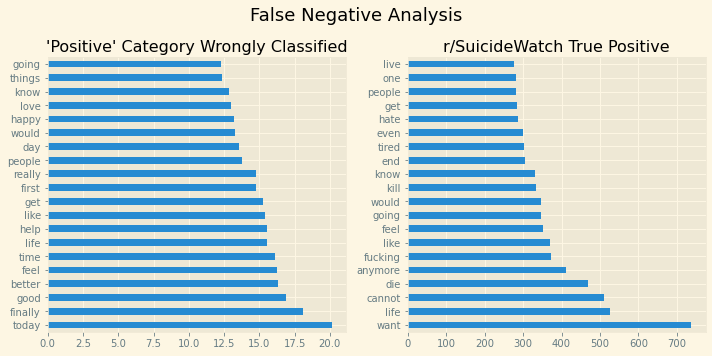

In [212]:
# plot top 20 words for false positive in 'positive' flair category, 
# and all true positives in r/SuicideWatch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[ \
    (common_words['is_suicidewatch']==False) & (common_words['flair_group']=='Positive') \
    ].drop(columns=add_col) \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'\'Positive\' Category Wrongly Classified')

common_words[ \
    (common_words['is_suicidewatch']==True) & (common_words['true_positive']==True) \
    ].drop(columns=add_col) \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/SuicideWatch True Positive')

plt.suptitle('False Negative Analysis', fontsize=18)
plt.tight_layout()

In [215]:
# Add top 2 common words to stopwords that are close together in ranking
custom_stopwords = custom_stopwords + ['like','feel']

In [216]:
# Set up MultinomialNB and TfidfVectorizer pipeline
pipe5 = Pipeline([
    ('tfvec5', TfidfVectorizer(stop_words= custom_stopwords)),
    ('nb5', MultinomialNB())
])

In [217]:
# Define parameters based on best parameters of model 3 
pipe5_params = {
    'tfvec5__max_features': [500],
    'tfvec5__min_df': [.03],
    'tfvec5__max_df': [.95],
    'tfvec5__ngram_range': [(1,2)],
    'nb5__alpha': [0.37]
}

In [218]:
# Instantiate GridSearchCV.
gs_pipe5 = GridSearchCV(pipe5, param_grid=pipe5_params, cv=5, verbose=1, n_jobs=-1)

In [219]:
# Fit GridSearch to training data.
gs_pipe5.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [220]:
# Best parameters of TfidfVectorizer and MultinomialNB.
gs_pipe5.best_params_

{'nb5__alpha': 0.37,
 'tfvec5__max_df': 0.95,
 'tfvec5__max_features': 500,
 'tfvec5__min_df': 0.03,
 'tfvec5__ngram_range': (1, 2)}

In [221]:
# Summary scores of TfidfVectorizer and MultinomialNB.
print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe5.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe5.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe5.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.773

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.778
Testing corpus accuracy = 0.771


C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


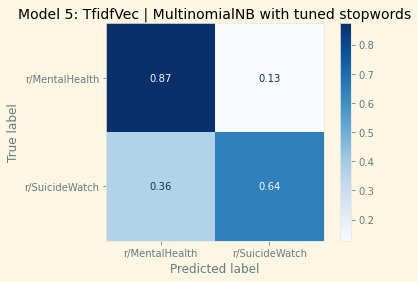

In [223]:
# Generate confusion matrix
y_pred = gs_pipe5.predict(X_test)
confusion_matrix(y_test, # True values.
                 y_pred)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

# Adding the scores into summary_df.
summary_df.loc[5] = [
    'TfidfVectorizer (tuned stopwords) | MultinomialNB',
    round(gs_pipe5.best_score_, 3),
    round(metrics.accuracy_score(y_test, y_pred),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    str(gs_pipe5.best_params_),
]

# Plot Confusion Matrix
plot_confusion_matrix(gs_pipe5, X_test, y_test, cmap='Blues', 
                      display_labels=['r/MentalHealth', 'r/SuicideWatch'],
                      normalize='true');  
plt.title(label="Model 5: TfidfVec | MultinomialNB with tuned stopwords", fontsize=14)
plt.grid(False)

In [224]:
summary_df

,transformer_estimator,best_score,accuracy,sensitivity,specificity,best_params
1,CountVec | LogisticRegression,0.786,0.783,0.751,0.808,"{'cvec1__max_df': 0.95, 'cvec1__max_features':..."
2,TfidfVec | LogisticRegression,0.792,0.792,0.739,0.834,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': ..."
3,TfidfVec | MultinomialNB,0.774,0.775,0.644,0.877,"{'nb3__alpha': 0.37, 'tfvec3__max_df': 0.95, '..."
4,TfidfVec | RandomForest,0.781,0.776,0.704,0.833,"{'rf__max_features': 'sqrt', 'rf__n_estimators..."
5,TfidfVectorizer (tuned stopwords) | MultinomialNB,0.773,0.771,0.642,0.873,"{'nb5__alpha': 0.37, 'tfvec5__max_df': 0.95, '..."


### Conclusion & Recommendation

We would recommend TfidfVectorizer with MultinomialNB as the better model for building a classification model for the purposes of building a filter to filter out incorrect or abusive flags of posts that contain thoughts of suicide.

Based on our false positive analysis, we tuned out two stop words and successfull increased specificity as intended. However, this came at the cost of other metrics. I believe that the 4 percentage point improvement is noteworthy given that the data used for stop words tuning was only 3% of the total false positive results.

### Next Steps

Further studies could involve Topic Modelling and Sentiment Analysis to group posts by topic to further improve tuning of the model.
